In [1]:
from project.models.char_baseline import CharSeqBaseline
from project.models.code2vec_solo import Code2VecSolo
from project.models.code2vec_encoder import Code2VecEncoder
from project.models.hashtable_baseline import  HashtableBaseline
from project.models.base_model import _run_model


/home/ehambro/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
load_dir = {"logdir":"logs/new_attention_fourfive_c2v_solo_canond0.1/best_bleu", "mode":"RETURN"}
# load_dir = {"logdir":"logs/reboot_fourfive_c2vmaskargs_bleu", "mode":"RETURN"}
# load_dir = {"logdir":"logs/reboot_fourfive_c2vmaskall_bleu", "mode":"RETURN"}
# load_dir = {"logdir":"logs/reboot_sixth", "mode":"RETURN"}

LOADED = _run_model(Code2VecSolo, **load_dir)

LOADING FROM: logs/new_attention_fourfive_c2v_solo_canond0.1/best_bleu, overwriting kwargs


Loading GloVe weights and word to index lookup table


400000it [00:07, 53425.88it/s]


Creating char to index look up table
Tokenizing the word descriptions and characters
Tokenizing the src code
Extracting tensors train and test
INFO:tensorflow:Restoring parameters from logs/new_attention_fourfive_c2v_solo_canond0.1/best_bleu/BasicModel.ckpt-36005


0822_10:36 WARNING - Loaded from logs/new_attention_fourfive_c2v_solo_canond0.1/best_bleu: Global Step 36005


In [3]:
from project.data.preprocessed.no_dups_X import no_dups_X_data


from project.data.preprocessed import load_vocab

from project.utils.tokenize import nltk_tok
from tqdm import tqdm


path2idx, path2cnt = load_vocab('no_dups_X', 'quickload_paths')
tv2idx, tv2cnt = load_vocab('no_dups_X', 'quickload_tvs')
idx2tv = {v:k for k,v in tv2idx.items()}
idx2path ={v:k for k,v in path2idx.items()}
RAW_TEST_DATA = no_dups_X_data().test
sess, nn, data_tuple, step = LOADED

In [4]:
import random
import numpy as np
from tqdm import tqdm 
from project.external.nmt import bleu


def prep_samples(translations, sample_size, no_samples):
    for n in range(no_samples):
        yield  random.choices(translations, k=sample_size)
        
def get_translations(nn, data):
    return nn.evaluate_bleu(sess, data, max_translations=10000)

def get_bleu_bootstrap(translations, sample_size = 1000, no_samples = 1000):
    bleu_bootstrap = []
    total = []
    for sample in prep_samples(translations, sample_size, no_samples):
        all_references = [[t.description] for t in sample]
        all_translations = [t.translation for t in sample ]
        b = bleu.compute_bleu(all_references, all_translations, max_order=4, smooth=False)
        bleu_bootstrap.append(b[0]*100)
    return bleu_bootstrap
    

In [5]:
from collections import defaultdict
import numpy 
from matplotlib import pyplot as plt
def translate_paths(paths, tvs):
    return["{} : {}".format(idx2path[p], idx2tv[t]) for p,t in zip(np.trim_zeros(paths), np.trim_zeros(tvs))]

def translate_paths_latex(paths, tvs):
    return["{} : \mintinline[]{python}{{}}".format(idx2path[p], idx2tv[t]) for p,t in zip(np.trim_zeros(paths), np.trim_zeros(tvs))]
def gen_combined_dataset(data_tuple_test):
    
    combined= []
    DESC_TO_D = defaultdict(list)
    [DESC_TO_D["".join(nltk_tok(f['arg_desc']))].append(f) for f in RAW_TEST_DATA]
    
    for i, d in enumerate(zip(*data_tuple_test)):
        matches = []
        for f in DESC_TO_D["".join(d[-1])]:
            arg_name = "".join(nn.translate(d[0], lookup=nn.idx2char, do_join=False))
            src_tokens = [idx2tv[t] for t in d[3] if t not in [0,1]]
            if arg_name.startswith(f['arg_name']) and all([str(s) in f['src'] for s in src_tokens]):
                
                matches.append((d,f, translate_paths(np.trim_zeros(d[2]),np.trim_zeros(d[3]))))
            
            if len(matches) > 1:
                break
        
        if len(matches)==1:
            combined.append(matches[0])
    return combined
        
COMB = gen_combined_dataset(data_tuple.test) 

In [6]:
def stack_from_comb(comb,x):   
    return [np.stack([d[i] for d, src,  p in comb][:x]) for i in range(4)] + [[d[-1] for d, src,  p in comb][:x]]
INPUT_STACKED = stack_from_comb(COMB, 63)  
nn._do_shuffle = False
T300  = get_translations(nn, INPUT_STACKED)

In [7]:
# import project.utils.code_tokenize as ct
# for i,  (t,c) in enumerate(zip(T300[-1], COMB)):
#     print(i, t)
#     print()
#     print(i, ct.get_pure_src(c[1]))
    
        

In [8]:
def print_light_table(labels, ptvs):
    # HACK
    to_tex = lambda  s:s.replace("<U", "$<$U").replace("K>", "K$>$").replace("_","\\_").replace("<-", "$\leftarrow$").replace("->", "$\\rightarrow$")
    
    reverse_this = []
    reverse_this.append("\end{tabular}")
    for l, p in zip(labels, ptvs):
        reverse_this.append(to_tex("    {} & {} \\\\".format(l, p)))
    reverse_this.append("\\begin{tabular}{c l}")
    print("\n".join(reversed(reverse_this)))

def translate_paths_latex(paths, tvs):
    return["{} : \mintinline[]{}{}".format(idx2path[p], "{python}","{"+idx2tv[t]+"}") for p,t in zip(np.trim_zeros(paths), np.trim_zeros(tvs))]
    
def plot_attention_single(attn, trans, paths, tvs, figsize=(10,5)):

    fig, ax = plt.subplots(1,figsize=figsize )
    ax = [ax]
    j=0
    
    F="ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    attention = [a for a in np.trim_zeros(attn)]
    ptvs = translate_paths_latex(paths, tvs)
    
    attention, ptvs = zip(*sorted(zip(attention, ptvs), key=lambda x:x[0]))
    labels = ["Path {}".format(F[i] if i < len(F) else i) for i in reversed(range(len(ptvs)))]
    
    
    ax[j].barh(np.arange(len(attention)), attention)
    
    ax[j].set_title("Attention Scores per Path".format(F[j]), fontsize=22) #loc="right", fontsize=18)
    ax[j].set_yticks(np.arange(len(labels)))
    ax[j].set_yticklabels( labels, rotation=0,  fontsize=18)
    ax[j].set_ylabel("Paths", fontsize=22)
    ax[j].set_xlabel("Attention Scores", fontsize=22)
    
    print_light_table(labels,ptvs)
#     plt.tight_layout()
    plt.show()

In [9]:
def latex_translation(t):
    to_tex = lambda  s:s.replace("<", "$<$").replace(">", "$>$").replace("_","\\_")
    split = 25
    n1 = t[0][:split]
    n1 = "\\textbf{Argument}: \mintinline[]{python}{" + to_tex("".join(n1)) + "}"
    if len(t[0]) > split:
        n1 += "...\\\\\n...\mintinline[]{python}{"+to_tex(" ".join(t[0][split:])) + "}"
    n1 += "\\\\"
    desc = "\\textbf{D}: " + to_tex(" ".join(t[1])) + "\\\\"
    pred = "\\textbf{P}: " + to_tex(" ".join(t[3])) + "\\\\"
    return "\n".join([n1, desc, pred])

    

In [10]:
def save_graph(name, svg):
    with open('./example_graphs/{}.svg'.format(name),'w') as f:
        f.write(svg._data)
        
def src_to_latex(src):
    return """\\begin{listing}[h!]
\\begin{minted}[]{python}
"""+src+"""
\end{minted}
\end{listing}
"""

In [11]:
def get_settings(**kwargs):
    settings = dict(
        # Styling options:
        scale=2,
        font='courier',
        shape='none',
        terminal_color='#008040',
        nonterminal_color='#004080',
        fontsize='22',

        # AST display options:
        omit_module=True,
        omit_docstrings=True,

        # Rendering engine is expected to expose "render" function
        renderer=showastfork.Renderers.graphviz,

        ignore_nodes=["Load","Store", "arguments"],
    )
    settings.update(kwargs)
    return settings

In [12]:
import pickle
def load_examples(name):
    with open("examples/{}.eg.pkl".format(name), 'rb') as f:
         examples = pickle.load(f)
    return examples

def save_examples(name, good_data_tuple):
    with open("examples/{}.eg.pkl".format(name), 'wb') as f:
        pickle.dump(good_data_tuple, f)


In [13]:
# save_examples("COMBINED_FAVES_REPORT",comb_faves)

\begin{tabular}{c l}
    Path A & Name $\leftarrow$ comprehension $\leftarrow$ ListComp $\leftarrow$ Assign $\rightarrow$ Name : \mintinline[]{python}{palette} \\
    Path B & Name $\leftarrow$ comprehension $\leftarrow$ ListComp $\leftarrow$ Assign $\leftarrow$ FunctionDef $\rightarrow$ Assign $\rightarrow$ ListComp $\rightarrow$ comprehension : \mintinline[]{python}{$<$UNK$>$} \\
    Path C & $<$UNK$>$ : \mintinline[]{python}{color\_palette} \\
    Path D & Name $\leftarrow$ comprehension $\rightarrow$ Name : \mintinline[]{python}{name} \\
    Path E & $<$UNK$>$ : \mintinline[]{python}{palette} \\
    Path F & $<$UNK$>$ : \mintinline[]{python}{palette} \\
    Path G & $<$UNK$>$ : \mintinline[]{python}{len} \\
    Path H & $<$UNK$>$ : \mintinline[]{python}{name} \\
    Path I & $<$UNK$>$ : \mintinline[]{python}{$<$UNK$>$} \\
\end{tabular}


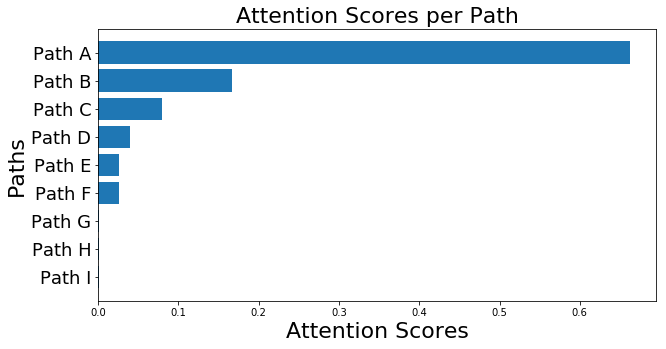

\textbf{Argument}: \mintinline[]{python}{colors$<$END$>$}\\
\textbf{D}: list of keys in the `` seaborn.xkcd\_rgb `` dictionary .\\
\textbf{P}: a list of data to read . if none , all other the first will be returned .\\
\begin{listing}[h!]
\begin{minted}[]{python}
def xkcd_palette(colors):
    """

    """
    palette = [xkcd_rgb[name] for name in colors]
    return color_palette(palette, len(palette))

\end{minted}
\end{listing}



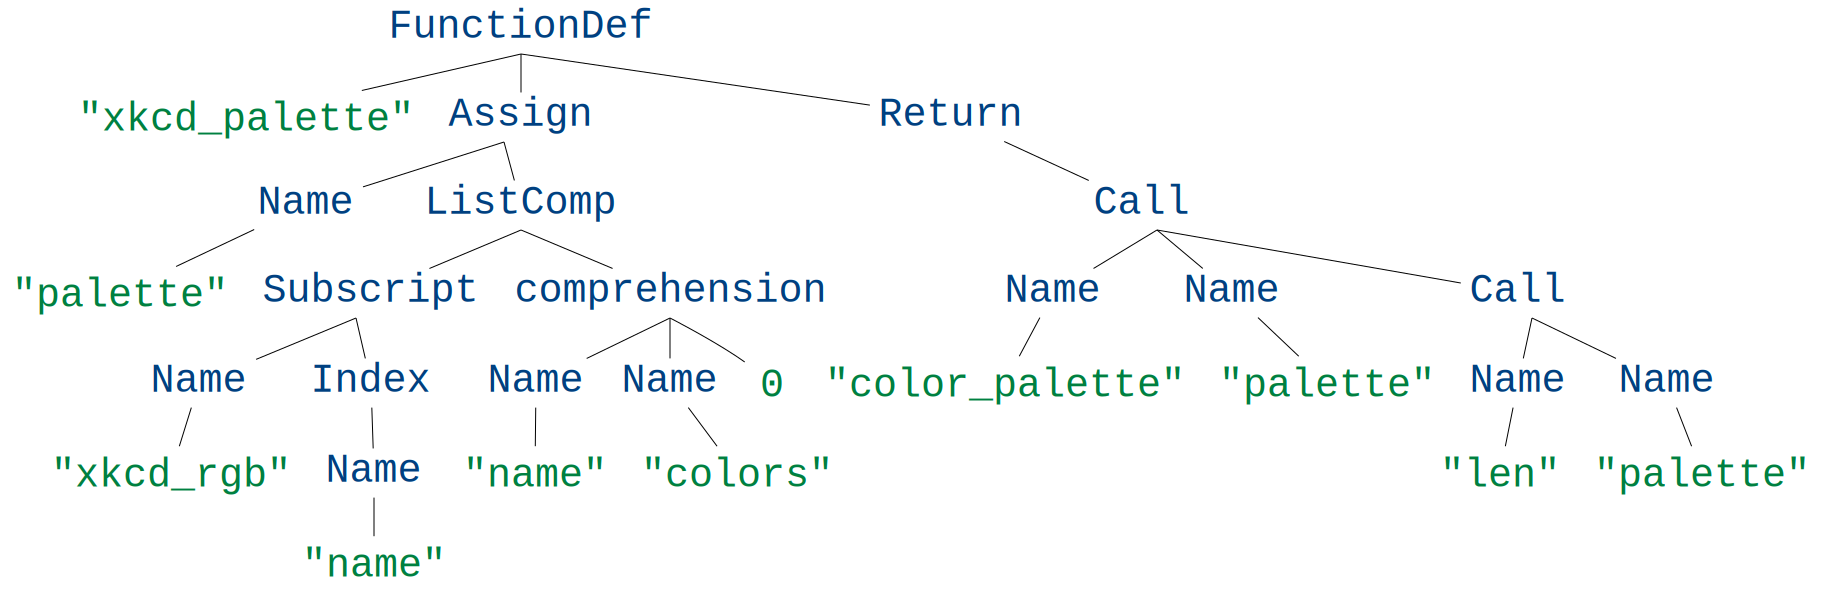

In [14]:
import showastfork
import importlib
importlib.reload(showastfork)
import project.utils.code_tokenize as ct


def get_attn_translation(nn, sess, data):
    [attn] =  nn._feed_fwd(sess, data, [nn.attention_scores] )
    trans = get_translations(nn, data)
    return zip(attn, trans[-1], data[2], data[3])

def generate_reports_GRAPH_TABLE_TREE_CODE(comb_faves, data_input, max_no, nn, sess):
    x = []
    i = 0 
    for (attn, trans, paths, tvs), comb in zip(get_attn_translation(nn,sess, data_input), comb_faves):
        plot_attention_single(attn, trans, paths, tvs)
        print(latex_translation(trans))
        print(src_to_latex(ct.get_pure_src(comb[1])) )
        x.append(showastfork.show_ast(ct.get_ast(comb[1]), get_settings(), True))
        i += 1
        if i == max_no:
            break
    # save_graph('xkcd_palette_strip', x[0])

comb_faves = load_examples("COMBINED_FAVES_REPORT")
data_input = stack_from_comb(comb_faves, 10)
generate_reports_GRAPH_TABLE_TREE_CODE(comb_faves, data_input, 1, nn, sess)

In [15]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [16]:
def get_all_attention_weights(nn, data):
    nn._do_shuffle = False
    attention, translation = [], []
    for i, mb in nn._to_batch(data):
        [attn, trans] =  nn._feed_fwd(sess, mb, [nn.attention_scores, nn.inference_id])
        attention.append(attn)
        translation.append(trans)
    return attention, translation, data

    


In [23]:
attn, trans, data = get_all_attention_weights(nn, data_tuple.valid)


In [18]:
def plot_hist(data_and_labels):
    fig, ax = plt.subplots(1, figsize=(16,8))
    for x,l,a in data_and_labels:
        ax.hist(x, density=True , bins=50, alpha=a, label=l)
    ax.set_title("Histogram of Attention Entropy for Code2Vec Decoder Model", fontsize=22)
#     yt = ax.get_yticks()
#     set 
#     yt = ["{:.2f}%".format(y)  for y in  100*yt/len(x)]
#     ax.set_yticklabels( yt, rotation=0,  fontsize=18)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
    ax.set_ylabel("Frequency (%)", fontsize=22)
    ax.set_xlabel("Attention Entropies", fontsize=22)
    ax.legend(fontsize = 'xx-large')
    plt.show()

In [174]:
(attn_weights_c2v, all_trans_c2v, entropies_c2v) = load_examples( "FOURTH_FIFTH_attn_weight_entropies_CODE2VEC_SOLO",  )
(attn_weights_c2v_margs, all_trans_c2v_margs, entropies_c2v_margs) = load_examples( "FOURTH_FIFTH_attn_weight_entropies_CODE2VEC_MASK_ARGS",  )
(attn_weights_c2v_mall, all_trans_c2v_mall, entropies_c2v_mall) = load_examples( "FOURTH_FIFTH_attn_weight_entropies_CODE2VEC_MASK_ALL",  )
(attn_weights_c2v_enc, all_trans_c2v_enc, entropies_c2v_enc) = load_examples( "SIXTH_attn_weight_entropies_CODE2VEC_ENC",  )
rows = [np.trim_zeros(row) for array in attn for row in array]

entropies = [-np.sum(r * np.log(r)) for r in rows]
uniform_entropies = [-np.log(1./len(r)) for r in rows]

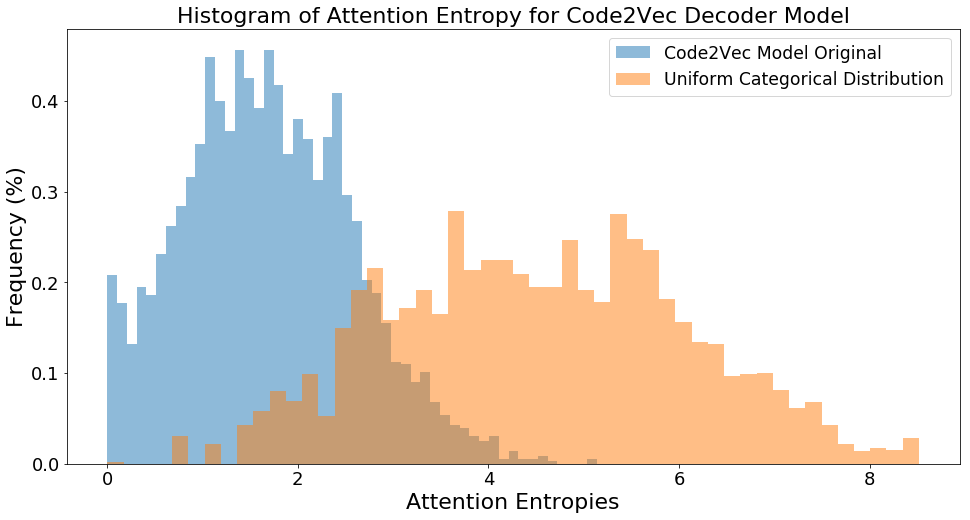

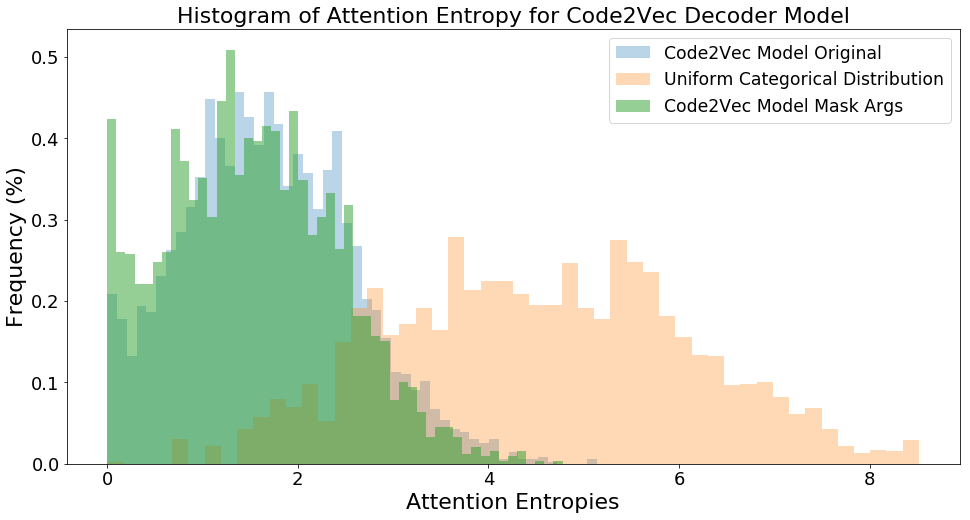

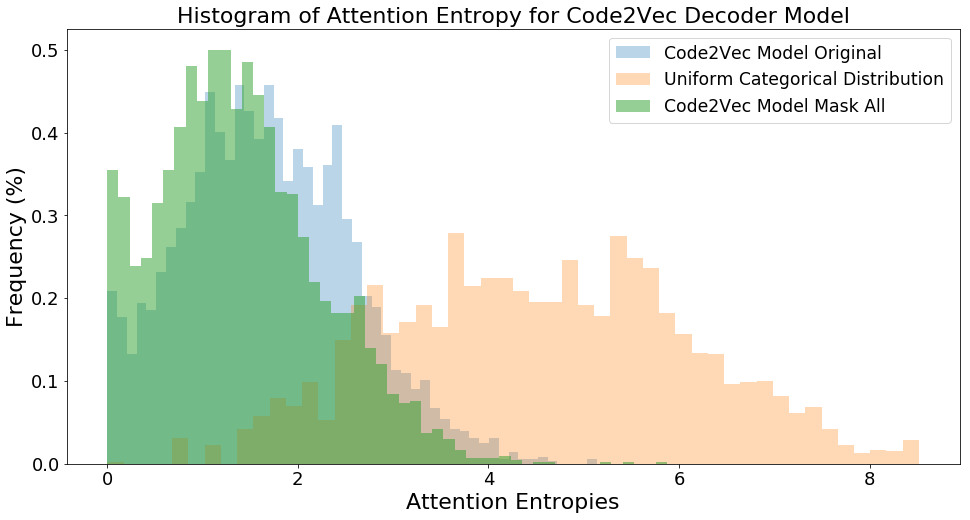

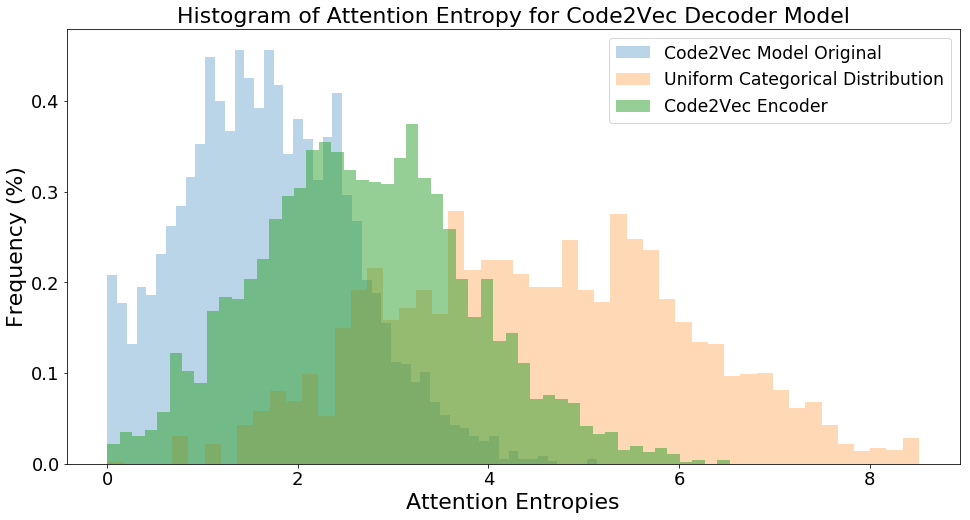

In [233]:
plot_hist([
    (entropies_c2v,'Code2Vec Model Original', 0.5),
    (uniform_entropies,'Uniform Categorical Distribution', 0.5), 
])

plot_hist([
    (entropies_c2v,'Code2Vec Model Original', 0.3),
    (uniform_entropies,'Uniform Categorical Distribution', 0.3), 
    (entropies_c2v_margs,'Code2Vec Model Mask Args', 0.5),
])

plot_hist([
    (entropies_c2v,'Code2Vec Model Original', 0.3),
    (uniform_entropies,'Uniform Categorical Distribution', 0.3), 
    (entropies_c2v_mall,'Code2Vec Model Mask All', 0.5)
])

plot_hist([
    (entropies_c2v,'Code2Vec Model Original', 0.3),
    (uniform_entropies,'Uniform Categorical Distribution', 0.3), 
    (entropies_c2v_enc,'Code2Vec Encoder', 0.5)
])
# sorted(uniform_entropies)

In [256]:
from project.models.hashtable_baseline import HashtableBaseline, _run_model
reload(hashtable_baseline)
HashtableBaseline = hashtable_baseline.HashtableBaseline
_run_model = hashtable_baseline._run_model

# HB.train(data_tuple.train)

def load_baseline(load_dir,mode):
    with open(load_dir['logdir']+'/args.pkl', 'rb') as f:
        args = pickle.load(f)
        args['code_mode'] = [mode]
        args['n_times'] = 1
        args['logfile'] = load_dir['logdir']+'/hashtable_main'
    return _run_model(**args)

In [221]:
HB, data = load_baseline(load_dir,"code_only_hardest")

Loading GloVe weights and word to index lookup table


400000it [00:07, 53296.06it/s]
  2%|▏         | 433/24197 [00:00<00:05, 4320.76it/s]


------------------------------------------------------
------------------------------------------------------
MODEL: HashtableBaseline
Name: Hashtable Model

Args: code_mode: hardest, code_only: True
------------------------------------------------------
ARGS:
batch_size : 64
bidirectional : True
char_seq : 60
code_mode : ['code_only_hardest']
code_tokenizer : code2vec
desc_embed : 200
desc_seq : 120
dropout : 0.1
epochs : 100
git : b"'d2c92d1'"
learning_rate : 0.001
logdir : /home/ehambro/EWEEZ/project/logs
logfile : logs/new_attention_fourfive_c2v_solo_canond0.1/best_bleu/hashtable_main
lstm_size : 300
n_times : 1
name : RUN
no_dups : 10
path_embed : 300
path_seq : 5000
path_vocab : 15000
save_every : 1
test_freq : 200
test_translate : 5
tokenizer : var_only
use_full_dataset : True
use_split_dataset : False
vec_size : 300
vocab_size : 40000
------------------------------------------------------
------------------------------------------------------



12.694582336204876
----- 1 -----
VALID  12.69458 +/-  0.00000   TEST  14.04897 +/-  0.00000 
      & $ 12.69458 \pm  0.00000 $ & $ 14.04897 \pm 0.00000 $ &
Mode: code_only_hardest,  Score 12.69458 +/- 0.00000


In [222]:
hb_trans = HB.test(d[1])

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
def get_bleu_from_translation(HB, hb_trans):
    bleu_scores = [sent_bleu([t.description], t.translation[1:-1]) for t in hb_trans]
    return bleu_scores

def get_sentence_samples(bleu_scores, translations, max_no):
    bleu_points = [0,0,0,1,3,5,7,9,10,10,]
    
    print("\\begin{table}\n\\begin{center}\n\\begin{tabular}{l}\n")
    print("\nA Random Sample of Bleu Scores \\\\ \n\n ")
    
    for i, b, h in zip(range(max_no),bleu_scores, translations):
        print("\\textbf{B}:"+" {:.3f}".format(b))
        print("\\textbf{C}:"+ " {:.1f}%  \\\\".format(100/h.choices))
        print(latex_translation(h))
        print("\\\\")
    
    print("\\hline\\\\\\\\")
    greater_than_point5 = [(b,t) for b,t in zip(bleu_scores, translations) if b>0.001]
    
    print("\n\nA Random Sample of Bleu Scores $>0.5$ \\\\\\\\ \n\n")
    for i, (b, h )in zip(range(3),greater_than_point5):
        print("\\textbf{B}:"+" {:.3f}".format(b))
        print("\\textbf{C}:"+ " {:.1f}%  \\\\".format(100/h.choices))
        print(latex_translation(h))
        print()
    
    print("\end{tabular}\n\end{center}\n\end{table}\n")
    

In [228]:
hb_trans = HB.test(d[1])
get_sentence_samples(bs_rl,hb_trans, 4)
bs_rl  = get_bleu_from_translation(HB, hb_trans)
rote_lerner_entropies = [-np.log(1.0/t.choices) for t in hb_trans]

\begin{table}
\begin{center}
\begin{tabular}{l}


A Random Sample of Bleu Scores \\ 

 
\textbf{B}: 0.000
\textbf{C}: 100.0%  \\
\textbf{Argument}: \mintinline[]{python}{key\_id}\\
\textbf{D}: optional key id used to identify this private key . this can be useful to associate the private key with its associated public key or certificate .\\
\textbf{P}: $<$START$>$ string , uri for token endpoint . for convenience defaults to google 's endpoints but any oauth 2.0 provider can be used . $<$END$>$\\
\\
\textbf{B}: 0.000
\textbf{C}: 100.0%  \\
\textbf{Argument}: \mintinline[]{python}{out}\\
\textbf{D}: if none , a new array is allocated .\\
\textbf{P}: $<$START$>$ the mode parameter determines how the array borders are handled , where $<$UNK$>$ is the value when mode is equal to $<$UNK$>$ ' . default is $<$UNK$>$ ' . $<$END$>$\\
\\
\textbf{B}: 0.000
\textbf{C}: 100.0%  \\
\textbf{Argument}: \mintinline[]{python}{tensor\_name\_regex}\\
\textbf{D}: the regular-expression pattern of the name 

/home/ehambro/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ehambro/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ehambro/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use S

In [234]:
from project.external.nmt import bleu
from nltk.translate.bleu_score import sentence_bleu
def sent_bleu(r, t):
    return sentence_bleu(r, t, weights=(0.25,0.25,0.25,0.25))

def score_bleu_individually(all_trans, all_attn, references, nn):
    flat_trans = [row for m in all_trans for row in m]
    flat_attn = [row for m in all_attn for row in m]

    flat_full_translations = [nn.translate(i, do_join=False, prepend_tok=nn.word2idx["<START>"])[1:-1] 
                              for i in flat_trans]
    bleu_scores = [sent_bleu([r], t) for r,t in zip(references, flat_full_translations)]
    return bleu_scores

bsc2v = score_bleu_individually(all_trans_c2v, attn_weights_c2v, data_tuple.valid[-1], nn)
bsc2v_margs = score_bleu_individually(all_trans_c2v_margs, attn_weights_c2v, data_tuple.valid[-1], nn)
bsc2v_mall = score_bleu_individually(all_trans_c2v_mall, attn_weights_c2v, data_tuple.valid[-1], nn)
bsc2e = score_bleu_individually(all_trans_c2v_enc, attn_weights_c2v, data_tuple.valid[-1], nn)



/home/ehambro/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ehambro/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ehambro/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use S

In [266]:
def plot_hist_2(data_and_labels):
    fig, ax = plt.subplots(1, figsize=(10,5))
    for x,l,a in data_and_labels:
        ax.hist(x, bins=50, alpha=a, label=l)
    ax.set_title("Histogram of Sentence Level Bleu Scores on Validation Set", fontsize=20)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    ax.set_ylabel("Counts", fontsize=18)
    ax.set_xlabel("Sentence Bleu Score", fontsize=16)
    ax.legend(fontsize = 'xx-large')
    plt.yscale('log')
    plt.show()

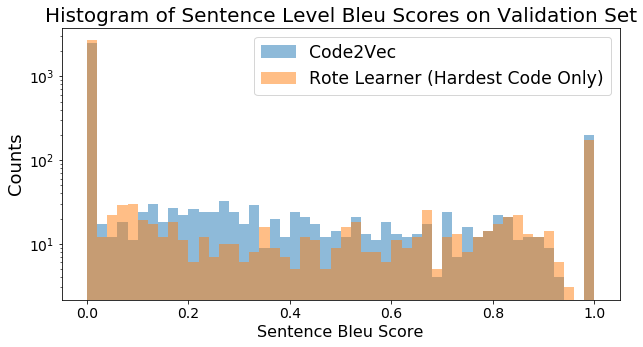

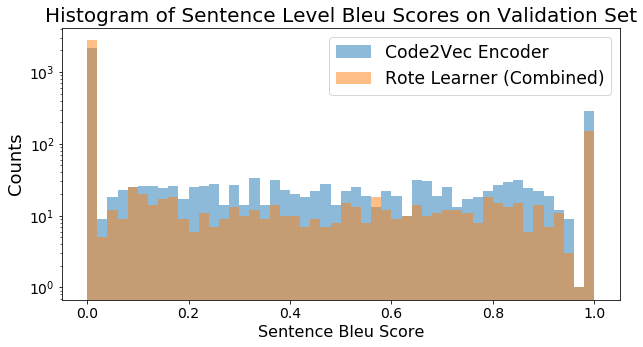

In [267]:
plot_hist_2([
    (bsc2v,'Code2Vec', 0.5), 
    (bs_rl,'Rote Learner (Hardest Code Only)', 0.5),
])

# HB_combined, d_combined = load_baseline(load_dir,"hardest")
# hb_trans_combined = HB_combined.test(d_combined[1])
# bs_rl_comb  = get_bleu_from_translation(HB_combined, hb_trans_combined)
# rote_comb_lerner_entropies = [-np.log(1.0/t.choices) for t in hb_trans_combined]
plot_hist_2([
    (bsc2e,'Code2Vec Encoder', 0.5), 
    (bs_rl_comb,'Rote Learner (Combined)', 0.5),
    
])


# ax.hist(bs_rl, alpha=0.5, bins=50, label='Rote Learner')
# ax.hist(bsc2v, alpha=0.5, bins=50, label='Code2Vec')
# ax.hist(bsc2v_mall, alpha=0.5, bins=50, label='Code2Vec Mask All')
# ax.hist(bsc2v_margs, alpha=0.5, bins=50, label='Code2Vec mask Args')
# # ax.hist(bsc2e, alpha=0.5, bins=50, label='Code2Vec Encoder')
# ax.legend()
# plt.yscale('log')
# plt.show()
# print(np.mean(bs_rl))
# print(np.mean(bsc2v))
# print(np.mean(bsc2v_mall))
# print(np.mean(bsc2v_margs))
# print(np.mean(bsc2e))

# def plot

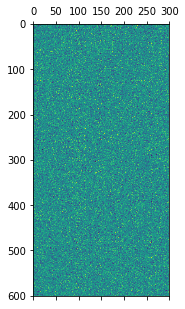

In [283]:
def get_weights():
    W = nn.get_scope_variable(sess, "code2vec_vector", "MLP_W")
    B = nn.get_scope_variable(sess, "code2vec_vector", "MLP_B")
#     print(B)
    fig, ax = plt.subplots(1,figsize=(10,5) )
    ax.matshow(W[0])
#     ax[1].bar(len(B[0]),B[0])
    

def get_weights_code2vec_encoder():
    
    pass


get_weights()

[array([[-0.23991781, -0.02425667, -0.19720219, ...,  0.17410858,
         -0.0268715 ,  0.27912265],
        [-0.2330796 ,  0.50508946, -0.9910714 , ...,  0.28539962,
          0.23898137,  0.19146979],
        [ 0.5786441 , -0.11734411, -0.5643527 , ...,  0.35738796,
         -0.01292353, -0.00145699],
        ...,
        [-0.04664467, -0.16197862,  0.19837682, ...,  0.16021141,
          0.28099233,  0.03872521],
        [-0.1097875 , -0.08058893,  0.42435786, ..., -0.05493631,
          0.16734251, -0.03735181],
        [ 0.41879076, -0.08526652, -0.3776235 , ..., -0.27159625,
         -0.35861847,  0.18433727]], dtype=float32)]

In [ ]:
y = [(i, d) for i, d in enumerate(zip(*data_tuple.test))]
y[0]
RAW_TEST_DATA[0]
data_tuple.test[-1][0]

In [ ]:
# bleu_bootstrap = get_bleu_bootstrap(T[-1], sample_size=1000, no_samples=1000)

In [ ]:
# print("{:.5f}, {:.5f}".format(np.mean(bleu_bootstrap), np.std(bleu_bootstrap)))

# print("{:.5f}, {:.5f}".format(np.mean(sorted(bleu_bootstrap)[25:-25]), np.std(sorted(bleu_bootstrap)[25:-25])))

In [ ]:
import pickle
from collections import namedtuple

Examples = namedtuple("Examples", ["translations", "data_tuple"])
def find_examples(translations, data_tuple):
    return_index = []
    return_data = [[] for  _ in data_tuple.test]
    for t in translations:
        for i,d in enumerate(data_tuple.test[-1]):
            arg_name = "".join(nn.translate(data_tuple.test[0][i], lookup=nn.idx2char, do_join=False))
            if d == t.description and arg_name == t.name:
                return_index.append(i)
    
    for j in return_index:
        for k, d in enumerate(return_data):
            d.append(data_tuple.test[k][j])
    
    return [np.stack(x) for x in return_data[:-1]] + [return_data[-1]]

def load_examples(name):
    with open("examples/{}.eg.pkl".format(name), 'rb') as f:
         examples = pickle.load(f)
    return examples

def save_examples(name, good_data_tuple):
    with open("examples/{}.eg.pkl".format(name), 'wb') as f:
        pickle.dump(good_data_tuple, f)


### 2 Funcname Otherargs

In [ ]:
# good_examples = [T[3][i] for i in [10, 12, 23, 83, 192, 213, 237, 240, 247, 263]]
# data_examples = find_examples(good_examples, data_tuple)        
# egs = Examples(good_examples,data_examples )
# egs = load_examples('second_exp_funcname_otherargs')

In [ ]:
from project.data.preprocessed import load_vocab
path2idx, path2cnt = load_vocab('no_dups_X', 'quickload_paths')
tv2idx, tv2cnt = load_vocab('no_dups_X', 'quickload_tvs')
idx2tv = {v:k for k,v in tv2idx.items()}
idx2path ={v:k for k,v in path2idx.items()}

def translate_paths(paths, tvs):
    return["{} : {}".format(idx2path[p], idx2tv[t]) for p,t in zip(np.trim_zeros(paths), np.trim_zeros(tvs))]

In [ ]:
# import tensorflow as tf
from matplotlib import pyplot as plt
j = 132
just_one = [ i[j:j+1] for i in data_tuple.test ]
paths = np.trim_zeros(just_one[2][0])
tvs = np.trim_zeros(just_one[3][0])
ptvs = translate_paths(paths, tvs)


path2idx, path2cnt = load_vocab('no_dups_1', 'quickload_paths')
tv2idx, tv2cnt = load_vocab('no_dups_1', 'quickload_tvs')
attention, translate = nn._feed_fwd(sess, just_one, [nn.attention_scores, nn.inference_id] )
# char_input = nn.translate(just_one[0][0], lookup=nn.idx2char, do_join=False)


word_output = nn.translate(translate[0], do_join=False)
print(word_output)
# # print(np.trim_zeros(just_one[0][0]).shape)

attn = np.trim_zeros(attention[0])
plt.figure(figsize=(8,8))
_, c = attention.shape
plt.bar(np.arange(len(attn)), attn)
plt.xticks(np.arange(len(ptvs)), ptvs, rotation=90)
# plt.yticks(np.arange(len(word_output)), word_output)
# print(moved.shape)
plt.show()


In [ ]:
# 10, 12, 23, 83, 192, 213, 237, 240, 247, 263, 
for i, t in enumerate(good_examples):
    print(i,t)

In [ ]:
char_embeddings = nn.get_scope_variable(sess, 'embed_vars', 'char_embed')

In [ ]:
len(data_tuple.test[-1])


In [ ]:
#"\n".join("\t".join([str(j) for j in i]) for i in char_embeddings[0]) 
print("\n".join(["Char"] + [nn.idx2char[i] for i in sorted(nn.idx2char.keys())]))
